In [1]:
import pandas as pd
from editdistance import eval as ed
import numpy as np
from address_compare.crf_tagger import AddressTagger
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
%pylab inline
import re
from sklearn import naive_bayes

ADDRESS_COLS = ["STREET_NUMBER", "PRE_DIRECTION", "STREET_NAME", "STREET_TYPE", "POST_DIRECTION",
                "UNIT_TYPE", "UNIT_NUMBER"]
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def digit_extract(s):
    re_digit_extract = re.compile('(^\d+$|\d+(?=st|nd|rd|th|ST|ND|RD|TH))')
    d = re_digit_extract.search(s)
    return d.group() if d is not None else ''

def series_ed(s1: pd.Series, s2: pd.Series):
    '''
    vectorizes edit distance over two pandas series
    :param s1: series of strings
    :param s2: series of strings
    :return: series of numbers
    '''
    df = pd.concat([s1, s2], axis=1)
    df.columns = ['a', 'b']
    return pd.concat([s1, s2], axis=1).apply(lambda x: ed(x[0], x[1]), axis=1, raw = True)

def edit_distance_matrix(df1: pd.DataFrame, df2: pd.DataFrame):
    out = pd.DataFrame()
    for col in ADDRESS_COLS:
        out[col] = series_ed(df1[col], df2[col])
    return out

def equal_features(df1: pd.DataFrame, df2: pd.DataFrame):
    out = pd.DataFrame()
    for col in ADDRESS_COLS:
        out[col+'_EQUAL'] = df1[col] == df2[col]
    return out

def number_mod_text(s1, s2):
    if (s1 == s2):
        return True
    d1 = digit_extract(s1)
    if d1:
        d2 = digit_extract(s2)
        return d1 == d2
    return False

def number_mod_text_series(s1, s2):
    return pd.concat([s1, s2], 1).apply(lambda x: number_mod_text(x[0], x[1]), 1, raw = True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from statsmodels.api import Logit
at = AddressTagger()

C:\Users\colin\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
full_data = pd.read_csv('address_compare/data/compare_train.csv')[['address_1', 'address_2', 'match']]

In [4]:
ad1 = at.series_to_address_df(full_data['address_1'], standardize=True)
ad2 = at.series_to_address_df(full_data['address_2'], standardize=True)
features = equal_features(ad1, ad2)
features['STREET_MOD_TEXT_EQUAL'] = number_mod_text_series(ad1['STREET_NAME'], ad2['STREET_NAME'])
features['const'] = 1
features = features.applymap(int)
train = np.random.binomial(1, .7, full_data.shape[0]) == 1
features[train]

,STREET_NUMBER_EQUAL,PRE_DIRECTION_EQUAL,STREET_NAME_EQUAL,STREET_TYPE_EQUAL,POST_DIRECTION_EQUAL,UNIT_TYPE_EQUAL,UNIT_NUMBER_EQUAL,STREET_MOD_TEXT_EQUAL,const
0,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1
5,1,0,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1
8,1,0,1,1,1,1,1,1,1
10,1,1,1,1,1,1,1,1,1
11,1,1,1,0,1,1,1,1,1
12,1,1,1,1,1,1,0,1,1


In [5]:
f = Logit(full_data[train]['match'], features[train])
f = f.fit()

Optimization terminated successfully.
         Current function value: 0.379775
         Iterations 8


In [6]:
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  match   No. Observations:                  102
Model:                          Logit   Df Residuals:                       93
Method:                           MLE   Df Model:                            8
Date:                Sun, 10 Dec 2017   Pseudo R-squ.:                  0.4483
Time:                        17:29:33   Log-Likelihood:                -38.737
converged:                       True   LL-Null:                       -70.210
                                        LLR p-value:                 1.228e-10
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
STREET_NUMBER_EQUAL       2.7754      1.166      2.381      0.017       0.491       5.060
PRE_DIRECTION_EQUAL       3.6668      1.138      3.223      0.001       1.437       5.897
STREET_NAME_EQUAL        -0.9185      1.202     -0.764      0.445      -3.274       1.437
STREET_TYPE_EQUAL         0.9073      0.919      0.987      0.324      -0.895       2.709
POST_DIRECTION_EQUAL      2.6239      0.919      2.856      0.004       0.823       4.425
UNIT_TYPE_EQUAL          -1.2607      1.403     -0.899      0.369      -4.011       1.489
UNIT_NUMBER_EQUAL         3.7055      1.140      3.249      0.001       1.470       5.941
STREET_MOD_TEXT_EQUAL     2.2625      1.366      1.656      0.098      -0.415       4.940
const                   -12.1697      2.860     -4.255      0.000     -17.776      -6.564
=========================================================================================
"""

In [7]:
full_data['prob'] = f.predict(features)

In [8]:
full_data[~train]

,address_1,address_2,match,prob
1,3703 E BROAD AVE,3704 E BROAD AVE,False,0.235
6,3703 E BROAD AVE,3703 BROAD AVENUE EAST,True,0.009
9,250 W AXTON RD,250 W AXTON ROAD,True,0.831
16,3104 234TH ST E UNIT A,3104 234 ST E STE A,True,0.978
21,3104 234TH ST E APT B,3104 234TH ST W UNIT A,False,0.030
24,A - 3105 234TH ST E,3104 234TH ST S UNIT A,False,0.005
25,3104 234TH ST E UNIT A,"STE A, 3104 234TH ST E",True,0.945
28,3104 234TH ST E UNIT A,3104 234TH ST E #A,True,0.945
29,3104 234TH ST E UNIT A,3104 234A ST E UNIT A,False,0.562
31,2835 OCEAN AVE #A,#A 2835 OCEAN AVENUE,True,0.831


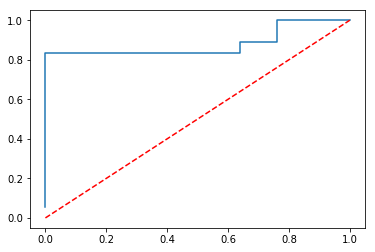

In [9]:
fpr, tpr, thresh = roc_curve(full_data[~train]['match'], full_data[~train]['prob'])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

In [10]:
roc_auc_score(full_data[~train]['match'], full_data[~train]['prob'])

0.88000000000000012

In [11]:
pd.concat([full_data, features], 1)[88:89]

,address_1,address_2,match,prob,STREET_NUMBER_EQUAL,PRE_DIRECTION_EQUAL,STREET_NAME_EQUAL,STREET_TYPE_EQUAL,POST_DIRECTION_EQUAL,UNIT_TYPE_EQUAL,UNIT_NUMBER_EQUAL,STREET_MOD_TEXT_EQUAL,const
88,21 154TH DR SE STE A,21 154 DR SOUTHEAST STE A,True,0.925,1,1,0,1,1,1,1,1,1


In [12]:
nb1 = naive_bayes.BernoulliNB()
nb1.fit(X=features[train], y=full_data[train]['match'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [13]:
full_data['nb1'] = nb1.predict_proba(features)[:,1]
full_data

,address_1,address_2,match,prob,nb1
0,3703 E BROAD AVE,3703 east broad ave,True,0.831,0.864
1,3703 E BROAD AVE,3704 E BROAD AVE,False,0.235,0.362
2,3703 E BROAD AVE,3703 E BROAD AV,True,0.831,0.864
3,3703 E BROAD AVE,3703 east broad avenue,True,0.831,0.864
4,3703 E BROAD AVE,3703 e broad avenue,True,0.831,0.864
5,3703 E BROAD AVE,3703 W BROAD AVE,False,0.112,0.427
6,3703 E BROAD AVE,3703 BROAD AVENUE EAST,True,0.009,0.135
7,250 W AXTON RD,250 WEST AXTON RD,True,0.831,0.864
8,250 W AXTON RD,250 EAST AXTON RD,False,0.112,0.427
9,250 W AXTON RD,250 W AXTON ROAD,True,0.831,0.864


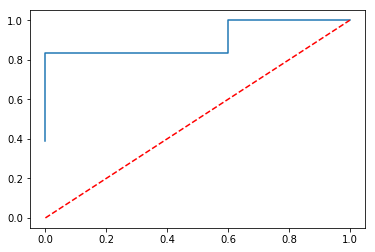

0.90000000000000002

In [14]:
fpr, tpr, thresh = roc_curve(full_data[~train]['match'], full_data[~train]['nb1'])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.show()
roc_auc_score(full_data[~train]['match'], full_data[~train]['nb1'])

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(features[train], full_data[train]['match'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [16]:
full_data['rf'] = rf.predict_proba(features)[:,1]

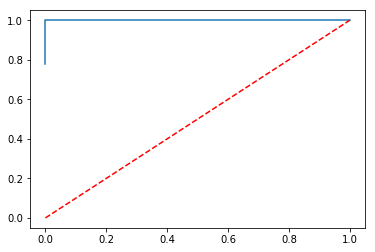

1.0

In [17]:
fpr, tpr, thresh = roc_curve(full_data[~train]['match'], full_data[~train]['rf'])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.show()
roc_auc_score(full_data[~train]['match'], full_data[~train]['rf'])

In [18]:
full_data

,address_1,address_2,match,prob,nb1,rf
0,3703 E BROAD AVE,3703 east broad ave,True,0.831,0.864,1.000
1,3703 E BROAD AVE,3704 E BROAD AVE,False,0.235,0.362,0.000
2,3703 E BROAD AVE,3703 E BROAD AV,True,0.831,0.864,1.000
3,3703 E BROAD AVE,3703 east broad avenue,True,0.831,0.864,1.000
4,3703 E BROAD AVE,3703 e broad avenue,True,0.831,0.864,1.000
5,3703 E BROAD AVE,3703 W BROAD AVE,False,0.112,0.427,0.000
6,3703 E BROAD AVE,3703 BROAD AVENUE EAST,True,0.009,0.135,0.475
7,250 W AXTON RD,250 WEST AXTON RD,True,0.831,0.864,1.000
8,250 W AXTON RD,250 EAST AXTON RD,False,0.112,0.427,0.000
9,250 W AXTON RD,250 W AXTON ROAD,True,0.831,0.864,1.000


In [19]:
fpr_logit, tpr_logit, thresh_logit = roc_curve(full_data[~train]['match'], full_data[~train]['prob'])
fpr_nb, tpr_nb, thresh_nb = roc_curve(full_data[~train]['match'], full_data[~train]['nb1'])
fpr_rf, tpr_rf, thresh_rf = roc_curve(full_data[~train]['match'], full_data[~train]['rf'])

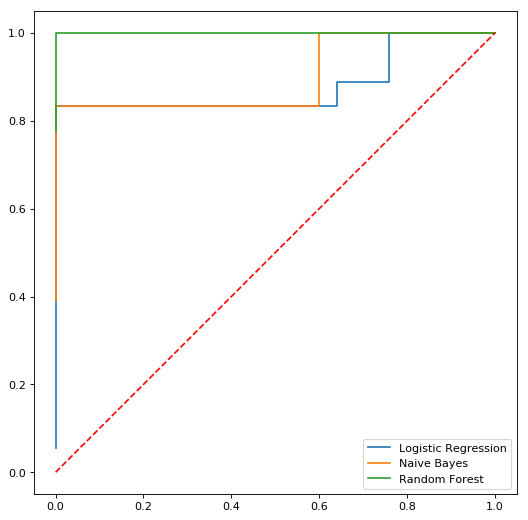

In [21]:
figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
roc_auc_score(full_data[~train]['match'], full_data[~train]['rf'])
roc_logit = plt.plot(fpr_logit, tpr_logit, label='Logistic Regression')
roc_naive_bayes = plt.plot(fpr_nb, tpr_nb, label='Naive Bayes')
roc_rf = plt.plot(fpr_rf, tpr_rf, label = 'Random Forest')
plt.plot([0, 1], [0, 1],'r--')
plt.axes().set_aspect("equal")
legend()

In [23]:
final_rf = RandomForestClassifier()
final_rf.fit(X = features, y = full_data['match'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [28]:
import pickle
with open('address_compare/trained_models/random_forest_1', 'wb') as f:
    pickle.dump(final_rf, f)